In [1]:
import tensorflow as tf
import glob
import imageio  # GIF를 만들기 위한 모듈
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [2]:
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 2s 0us/step


In [3]:
train_images.shape

(60000, 28, 28)

### dataset 생성

In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

In [5]:
train_images = (train_images - 127.5) / 127.5

데이터 배치를 만들고 섞음

In [6]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


# BEGAN 모델 만들기

In [8]:
# discriminator model의 학습범위를 제한하기 위해 Constraint class를 사용한다.
class ClipConstraint(tf.keras.constraints.Constraint):
    # set clip value when initialized
    def __init__(self, clip_value):
        self.clip_value = clip_value
        
    # clip model weights to hypercube
    def __call__(self, weights):
        return tf.clip_by_value(weights, -self.clip_value, self.clip_value)
    
    # get the config
    def get_config(self):
        return {'clip_value': self.clip_value}
    
def discriminator_model():
    const = ClipConstraint(0.01)
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=64, kernel_size=4, strides=(2,2), padding='same',kernel_constraint=const, input_shape=(28, 28, 1)),
        tf.keras.layers.LeakyReLU(),
        
        tf.keras.layers.Conv2D(filters=128, kernel_size=4, strides=(2,2), padding='same', kernel_constraint=const),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        
        tf.keras.layers.Reshape((7, 7, 128)),
        tf.keras.layers.Dense(1024),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        
        tf.keras.layers.Dense(1)
    ])
    return model

In [9]:
discriminator = discriminator_model()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1088      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         131200    
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
dense (Dense)                (None, 7, 7, 1024)        1

In [10]:
def generator_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=[64]),
        tf.keras.layers.Dense(1024),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),

        tf.keras.layers.Dense(128*7*7),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),

        tf.keras.layers.Reshape((7, 7, 128)),

        tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=4, strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),

        tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=4, strides=(2,2), padding='same'),
        tf.keras.layers.Activation(tf.nn.tanh)
    ])
    return model

In [11]:
generator = generator_model()
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1024)              66560     
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              4096      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 6272)              6428800   
_________________________________________________________________
batch_normalization_3 (Batch (None, 6272)              25088     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)        

In [12]:
# 출력 데이터 확인
noise = tf.random.normal([1, 64])
generator_image = generator(noise, training=False)

print(generator_image.shape)

(1, 28, 28, 1)


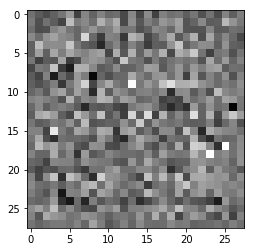

In [13]:
plt.imshow(generator_image[0, :, :, 0], cmap='gray')

### loss 와 optimizer 정의

In [14]:
def discriminator_loss(disc_output):
    return tf.reduce_mean(disc_output)

In [15]:
generator_optimizer = tf.keras.optimizers.RMSprop(0.002)
discriminator_optimizer = tf.keras.optimizers.RMSprop(0.002)

### 훈련 설정

In [16]:
noise_dim = 64
num_examples_to_generate = 16
EPOCHS = 50
k = 0  # training step마다 업데이트 됨
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [17]:
discriminator.trainable_weights[4].name

'batch_normalization/gamma:0'

In [18]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
        generated_image = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_image, training=True)
        
        d_loss_real = discriminator_loss(real_output)
        d_loss_fake = discriminator_loss(fake_output)
        
        disc_loss = d_loss_fake - d_loss_real
        gen_loss = -d_loss_fake
    
    gradients_of_discriminator = dis_tape.gradient(disc_loss, discriminator.trainable_variables)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

In [19]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4,4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5, cmap='gray')
        plt.axis('off')
    if not os.path.exists('images'):
        os.mkdir('images')
    plt.savefig('./images/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [20]:
x = tf.Variable([1,2,3], dtype=tf.float32)
y = tf.Variable([4,5,6], dtype=tf.float32)

tf.nn.l2_loss(y-x)

<tf.Tensor: shape=(), dtype=float32, numpy=13.5>

In [21]:
def train(dataset, start, epochs):
    for epoch in range(start, epochs):
        
        for image_batch in dataset:
            train_step(image_batch)
        # GIF를 위한 이미지를 바로 생성합니다.
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                epoch + 1,
                                seed)
        # 15 에포크가 지날 때마다 모델을 저장합니다.
        if (epoch + 1) % 15 == 0:
            if not os.path.exists('model'):
                os.mkdir('model')
            generator.save('./model/generator_{:04d}.h5'.format(epoch))
            discriminator.save('./model/discriminator_{:04d}.h5'.format(epoch))
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    # 마지막 에포크가 끝난 후 생성합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

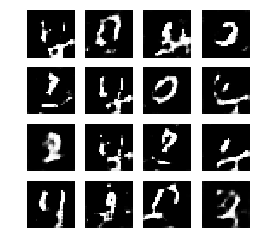

Time for epoch 2 is 1586510122.6098733 sec


In [ ]:
train(train_dataset, 0, EPOCHS)

### GIF 생성

In [ ]:
def display_image(epoch_no):
    return PIL.Image.open('./BEGAN_image/image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

imageio로 훈련 과정마다 저장된 이미지를 사용해 GIF 에니메이션을 만듭니다.

In [ ]:
glob.glob('BEGAN_image/image*.png')

In [ ]:
anim_file = 'mnist_began.gif'

with imageio.get_writer('BEGAN_image'+anim_file, mode='I') as writer:
    filenames = glob.glob('BEGAN_image/image*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)